In [49]:
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

#Settings for Pandas
pd.options.display.max_rows=10
pd.options.display.float_format = "{:.1f}".format

In [50]:
print(tf.__version__)

2.3.1


In [93]:
#Import Dataset
df = pd.read_csv('./dataset/housing.csv')
#Scale the label
df["median_house_value"] /= 1000.0
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.2,37.9,41.0,880.0,129.0,322.0,126.0,8.3,452.6,NEAR BAY
1,-122.2,37.9,21.0,7099.0,1106.0,2401.0,1138.0,8.3,358.5,NEAR BAY
2,-122.2,37.9,52.0,1467.0,190.0,496.0,177.0,7.3,352.1,NEAR BAY
3,-122.2,37.9,52.0,1274.0,235.0,558.0,219.0,5.6,341.3,NEAR BAY
4,-122.2,37.9,52.0,1627.0,280.0,565.0,259.0,3.8,342.2,NEAR BAY


In [94]:
df["ocean_proximity"].unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

In [95]:
#Reconfigure data frame. One hot encoding for ocean proximity
df["ocean_proximity"] = df["ocean_proximity"].astype("category")
df["ocean_proximity"] = df["ocean_proximity"].cat.codes
df["ocean_proximity"] = df["ocean_proximity"].map({0:'NEAR BAY',1:'<1H OCEAN',2:'INLAND',3:'NEAR OCEAN',4:'ISLAND'})
df = pd.get_dummies(df,prefix='',prefix_sep='')
print(df["total_bedrooms"].isnull().sum())
df = df.dropna()
df.tail()

207


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
20635,-121.1,39.5,25.0,1665.0,374.0,845.0,330.0,1.6,78.1,1,0,0,0,0
20636,-121.2,39.5,18.0,697.0,150.0,356.0,114.0,2.6,77.1,1,0,0,0,0
20637,-121.2,39.4,17.0,2254.0,485.0,1007.0,433.0,1.7,92.3,1,0,0,0,0
20638,-121.3,39.4,18.0,1860.0,409.0,741.0,349.0,1.9,84.7,1,0,0,0,0
20639,-121.2,39.4,16.0,2785.0,616.0,1387.0,530.0,2.4,89.4,1,0,0,0,0


In [96]:
#Describe the dataframe
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
count,20433.0,20433.0,20433.0,20433.0,20433.0,20433.0,20433.0,20433.0,20433.0,20433.0,20433.0,20433.0,20433.0,20433.0
mean,-119.6,35.6,28.6,2636.5,537.9,1424.9,499.4,3.9,206.9,0.3,0.0,0.1,0.4,0.1
std,2.0,2.1,12.6,2185.3,421.4,1133.2,382.3,1.9,115.4,0.5,0.0,0.3,0.5,0.3
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0,0.0,0.0,0.0,0.0,0.0
25%,-121.8,33.9,18.0,1450.0,296.0,787.0,280.0,2.6,119.5,0.0,0.0,0.0,0.0,0.0
50%,-118.5,34.3,29.0,2127.0,435.0,1166.0,409.0,3.5,179.7,0.0,0.0,0.0,0.0,0.0
75%,-118.0,37.7,37.0,3143.0,647.0,1722.0,604.0,4.7,264.7,1.0,0.0,0.0,1.0,0.0
max,-114.3,42.0,52.0,39320.0,6445.0,35682.0,6082.0,15.0,500.0,1.0,1.0,1.0,1.0,1.0


In [97]:
#Split into train and test dataset
training_df = df.sample(frac=0.8,random_state=0)
testing_df = df.drop(training_df.index)

In [27]:
#Functions for building the model
def build_model(learning_rate):
    #Call on Keras's sequential model
    model = tf.keras.models.Sequential()
    
    #Topography of model. Single node on
    #Single node, single layer
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))
    
    #Compile the model into code that tensorflow can execute.
    #Configure training to minimize models mean squared error
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=learning_rate),loss="mean_squared_error",
                 metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

In [28]:
#Functions for training the model
def train_model(model,df,features,label,epochs,batch_size):
    history = model.fit(x=df[features],y=df[label],batch_size=batch_size,epochs=epochs)
    
    #Gather the trained weights and bias
    trained_weight = model.get_weights()[0]
    trained_bias = model.get_weights()[1]
    
    #The epochs are stored separately from rest of the history
    epochs = history.epoch
    
    #Isolate error for each epoch
    hist = pd.DataFrame(history.history)
    
    #To track progression of the training, we will take snapshot
    #of model's root mean squared error at each epoch
    rmse = hist["root_mean_squared_error"]
    
    return trained_weight,trained_bias,epochs,rmse

In [29]:
#Plotting functions
def plot_the_model(trained_weight,trained_bias,features,label):
    plt.xlabel(features)
    plt.ylabel(label)
    
    #Scatter plot for 200 random points
    random_examples = training_df.sample(n=200)
    plt.scatter(random_examples[features],random_examples[label])
    
    #Draw the model line from x0,y0 to x1,y1
    x0 = 0
    y0 = trained_bias
    x1 = 10000
    y1 = trained_bias + (trained_weight*x1)
    plt.plot([x0,x1],[y0,y1],c='r')
    
    plt.show()

def plot_the_loss_curve(epochs,rmse):
    #Plot loss vs epochs
    plt.figure()
    plt.xlabel("Epochs")
    plt.ylabel("Root mean squared error")
    
    plt.plot(epochs,rmse, label="Loss")
    plt.legend()
    plt.ylim([rmse.min()*0.97,rmse.max()])
    plt.show()

Epoch 1/15
682/682 [==============================] - 1s 812us/step - loss: 142521.7656 - root_mean_squared_error: 377.5205
Epoch 2/15
682/682 [==============================] - 1s 833us/step - loss: 27580.4551 - root_mean_squared_error: 166.0736
Epoch 3/15
682/682 [==============================] - 1s 741us/step - loss: 26701.3438 - root_mean_squared_error: 163.4055
Epoch 4/15
682/682 [==============================] - 1s 747us/step - loss: 25817.5879 - root_mean_squared_error: 160.6785
Epoch 5/15
682/682 [==============================] - 0s 730us/step - loss: 24871.1289 - root_mean_squared_error: 157.7058
Epoch 6/15
682/682 [==============================] - 1s 753us/step - loss: 24318.6719 - root_mean_squared_error: 155.9445
Epoch 7/15
682/682 [==============================] - 1s 742us/step - loss: 23213.3301 - root_mean_squared_error: 152.3592
Epoch 8/15
682/682 [==============================] - 1s 750us/step - loss: 22811.5723 - root_mean_squared_error: 151.0350
Epoch 9/15
682/

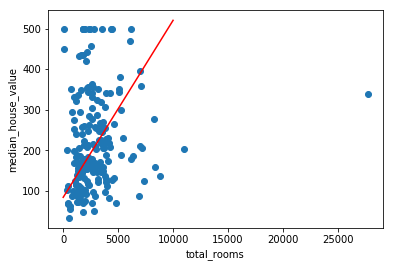

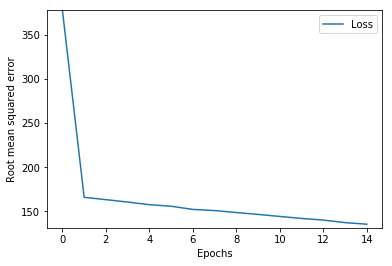

In [48]:
#Calling the model
#Define hyperparameters
learning_rate = 0.01
epochs = 15
batch_size = 30

#Creating a synthetic feature
training_df["rooms_per_person"] = training_df["total_rooms"]/training_df["population"]

#Feature and Label
my_feature = "total_rooms"
#my_feature = "rooms_per_person"
#my_feature = "median_income"
my_label = "median_house_value"

#Discard pre-existing values of model
my_model = None
my_model = build_model(learning_rate)
weight,bias,epochs,rmse = train_model(my_model,training_df,my_feature,my_label,epochs,batch_size)

print("Learned weight of model = ",weight)
print("Learned bias of model = ",bias)

plot_the_model(weight,bias,my_feature,my_label)
plot_the_loss_curve(epochs,rmse)

In [31]:
def predict_house_value(n,feature,label):
    "Predict house value based on a feature"
    
    batch = training_df[feature][10000:10000+n]
    predicted_values = my_model.predict_on_batch(x=batch)
    
    print("feature   label          predicted")
    print("  value   value          value")
    print("          in thousand$   in thousand$")
    print("--------------------------------------")
    
    for i in range(n):
        print ("%5.0f %6.0f %15.0f" % (training_df[feature][10000 + i],
                                   training_df[label][10000 + i],
                                   predicted_values[i][0] ))

In [43]:
predict_house_value(10,my_feature,my_label)

feature   label          predicted
  value   value          value
          in thousand$   in thousand$
--------------------------------------
    2    210             208
    2    182             205
    3    206             214
    2    195             215
    3    195             201
    3    362             168
    2    187             190
    2    157             207
    2    180             180
    2    172             183


In [44]:
training_df.corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_person
longitude,1.0,-0.9,-0.1,0.0,0.1,0.1,0.1,-0.0,-0.0,-0.3,-0.1
latitude,-0.9,1.0,0.0,-0.0,-0.1,-0.1,-0.1,-0.1,-0.1,0.2,0.1
housing_median_age,-0.1,0.0,1.0,-0.4,-0.3,-0.3,-0.3,-0.1,0.1,0.1,-0.1
total_rooms,0.0,-0.0,-0.4,1.0,0.9,0.9,0.9,0.2,0.1,-0.0,0.1
total_bedrooms,0.1,-0.1,-0.3,0.9,1.0,0.9,1.0,-0.0,0.0,-0.0,0.1
...,...,...,...,...,...,...,...,...,...,...,...
households,0.1,-0.1,-0.3,0.9,1.0,0.9,1.0,0.0,0.1,-0.0,-0.0
median_income,-0.0,-0.1,-0.1,0.2,-0.0,0.0,0.0,1.0,0.7,-0.0,0.2
median_house_value,-0.0,-0.1,0.1,0.1,0.0,-0.0,0.1,0.7,1.0,0.1,0.2
ocean_proximity,-0.3,0.2,0.1,-0.0,-0.0,-0.1,-0.0,-0.0,0.1,1.0,0.1
